In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import os
import logging
from germline_cnv_evaluation import CNVTrialCallSetEvaluator, CNVCallSetAnalysisSummary, GenericCNVCallSet

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')

## Load GS call-set

In [2]:
# the result of process_gs_calls.py
genome_strip_var_only_call_set_pkl = '/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/GPC2-WES/gs/\
gpc2_gs_callset_v3__CNV_eval_suite_ver__0.1__.pkl'

# for GS calls: no need to pad egments before merging (by design, the best segment for each sample
# is already there)
truth_merge_padding = 0

# for GS calls: choose the highest quality segment from the overlapping set (it is reasonable
# to assume that the highest quality segment for each sample is the right call for that sample)
truth_merge_interval_consensus_strategy = 'highest_quality'

# for GS calls: the intervals end-points are the same as the highest quality segment
truth_merge_call_consensus_strategy = 'highest_quality'

# load pickled results
truth_call_set_dict, truth_included_loci = GenericCNVCallSet.from_pickle(genome_strip_var_only_call_set_pkl)
truth_sample_names = list(truth_call_set_dict.keys())

# merge overlapping segments
truth_merged_call_set_dict = dict()
for sample_name in truth_sample_names:
    truth_merged_call_set_dict[sample_name] = truth_call_set_dict[sample_name].merge_overlapping_variants(
        truth_merge_padding,
        interval_consensus_strategy=truth_merge_interval_consensus_strategy,
        call_consensus_strategy=truth_merge_call_consensus_strategy)

## Load Umap track

In [3]:
def load_Umap_scores(ref_dict_file, umap_bedgraph_file, contigs, remove_chr_prefix_from_Umap=True):
    # load contig lengths
    contig_length_dict = {}
    with open(ref_dict_file, 'r') as f:
        for line in f:
            toks = line.strip().split('\t')
            if toks[0] == '@SQ':
                contig = toks[1][3:]
                length = int(toks[2][3:])
                if contig in contigs:
                    contig_length_dict[contig] = length

    # load Umap scores (note: 0-based)
    contig_umap_score_dict = {}
    for contig in contigs:
        # default to Umap score = 0
        contig_umap_score_dict[contig] = np.zeros((contig_length_dict[contig],))

    with open(umap_bedgraph_file, 'r') as f:
        for num, line in enumerate(f):
            if num == 0:
                continue
            toks = line.strip().split('\t')
            contig = toks[0]
            if remove_chr_prefix_from_Umap:
                contig = contig.replace("chr", "").upper()
            if contig not in contigs:
                continue
            start = int(toks[1])
            end = int(toks[2])
            score = float(toks[3])
            contig_umap_score_dict[contig][start:end + 1] = score
            if num % 1000000 == 0:
                print(str(num) + "...")

    return contig_umap_score_dict

mappability_root = "/Users/mehrtash/Codes/Python/SVCoverageCollection/"
hg19_dict = os.path.join(mappability_root, "Homo_sapiens_assembly19.dict")
hg19_umap_bedgraph_file = os.path.join(mappability_root, "hg19.k100.umap.multi.bedgraph")
hg19_contigs = [str(j) for j in range(1, 23)] + ['X', 'Y']

contig_umap_score_dict = load_Umap_scores(hg19_dict, hg19_umap_bedgraph_file, hg19_contigs,
                                          remove_chr_prefix_from_Umap=True)

1000000...
2000000...
3000000...
4000000...
5000000...
6000000...
7000000...
8000000...
9000000...
10000000...
11000000...
12000000...
13000000...
14000000...
15000000...
16000000...
17000000...
18000000...
19000000...
20000000...
21000000...
22000000...
23000000...
24000000...
25000000...
26000000...
27000000...
28000000...
29000000...
30000000...
31000000...
32000000...
33000000...
34000000...
35000000...
36000000...
37000000...
38000000...
39000000...
40000000...
41000000...
42000000...
43000000...
44000000...
45000000...
46000000...
47000000...
48000000...
49000000...
50000000...
51000000...
52000000...
53000000...
54000000...
55000000...
56000000...
57000000...
58000000...
59000000...
60000000...
61000000...
62000000...
63000000...


## GQ distribution

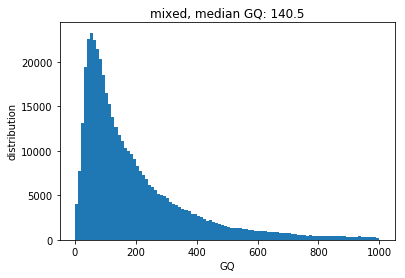

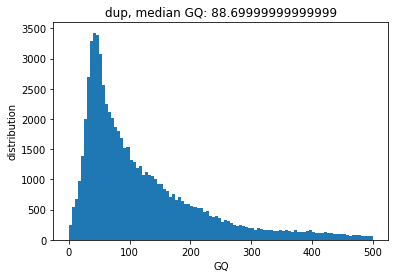

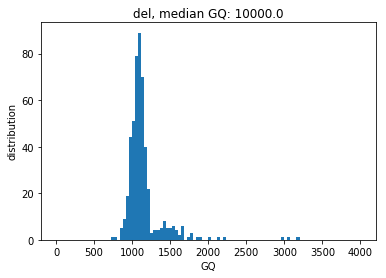

In [4]:
def get_GS_GQ_list_for_class(variant_class, contig_set=hg19_contigs):
    quality_list = []
    for si in range(len(truth_sample_names)):
        sample_call_set = truth_merged_call_set_dict[truth_sample_names[si]]
        for contig in contig_set:
            quality_list += [variant.quality for variant in sample_call_set.iter_in_contig(contig)
                             if variant.variant_class == variant_class]
    return quality_list

def plot_GS_GQ_hist(variant_class, max_GQ_plot):
    fig = plt.figure()
    ax = plt.gca()
    quality_list = get_GS_GQ_list_for_class(variant_class)
    _ = ax.hist(quality_list, range=(0, max_GQ_plot), bins=100)
    ax.set_xlabel('GQ')
    ax.set_ylabel('distribution')
    ax.set_title(variant_class + ", median GQ: {0}".format(np.median(quality_list)))
    return quality_list
    
_ = plot_GS_GQ_hist('mixed', 1000)
_ = plot_GS_GQ_hist('dup', 500)
_ = plot_GS_GQ_hist('del', 4000)

## Length distribution

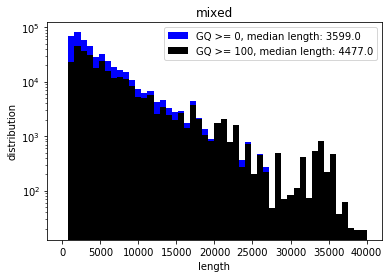

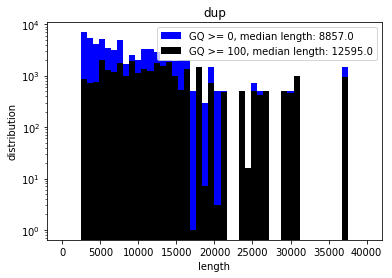

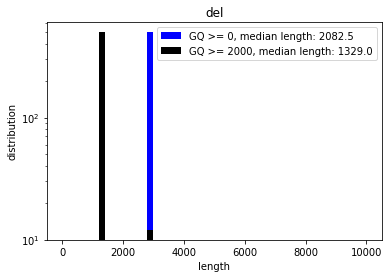

In [5]:
def get_GS_length_list_for_class(variant_class, contig_set, min_quality):
    length_list = []
    for si in range(len(truth_sample_names)):
        sample_call_set = truth_merged_call_set_dict[truth_sample_names[si]]
        for contig in contig_set:
            length_list += [variant.end - variant.start
                            for variant in sample_call_set.iter_in_contig(contig)
                            if variant.variant_class == variant_class
                            if variant.quality >= min_quality]
    return length_list

def plot_GS_length_hist(variant_class, contig_set, max_length_plot, min_quality_list, color_list):
    fig = plt.figure()
    ax = plt.gca()
    for min_quality, color in zip(min_quality_list, color_list):
        length_list = get_GS_length_list_for_class(variant_class, contig_set, min_quality)
        label = "GQ >= {0}, median length: {1}".format(min_quality, np.median(length_list))
        _ = ax.hist(length_list, range=(0, max_length_plot), bins=50, log=True, color=color, label=label)
    ax.set_xlabel('length')
    ax.set_ylabel('distribution')
    ax.legend()
    ax.set_title(variant_class)
    
plot_GS_length_hist('mixed', hg19_contigs, 40000, [0, 100], ['blue', 'black'])
plot_GS_length_hist('dup', hg19_contigs, 40000, [0, 100], ['blue', 'black'])
plot_GS_length_hist('del', hg19_contigs, 10000, [0, 2000], ['blue', 'black'])

## Umap distribution

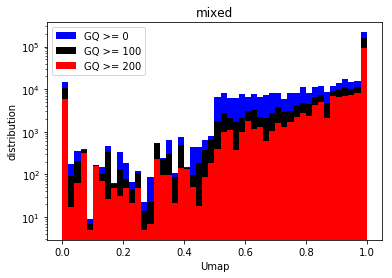

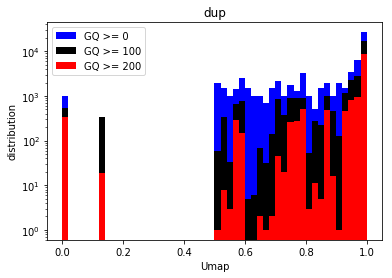

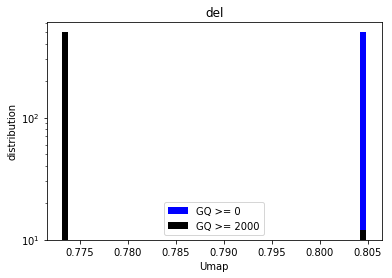

In [6]:
# calculate Umap mean score for intervals
def get_Umap_mean_score_for_interval(contig, start, end, contig_umap_score_dict):
    """interval is 1-based, end exluded"""
    return np.mean(contig_umap_score_dict[contig][start-1:end])

def call_set_Umap_score_generator(si, contig_set, variant_class, min_quality):
    sample_call_set = truth_merged_call_set_dict[truth_sample_names[si]]
    for contig in contig_set:
        for variant in sample_call_set.iter_in_contig(contig):
            if variant.quality < min_quality or variant.variant_class != variant_class:
                continue
            yield get_Umap_mean_score_for_interval(
                variant.contig, variant.start, variant.end, contig_umap_score_dict)
            

def get_GS_Umap_score_list_for_class(si, contig_set, variant_class, min_quality):
    Umap_scores = []
    for si in range(len(truth_sample_names)):
        Umap_scores += [score for score in call_set_Umap_score_generator(si, contig_set, variant_class, min_quality)]
    return Umap_scores

def plot_GS_Umap_score_hist(contig_set, variant_class, min_quality_list, color_list):
    fig = plt.figure()
    ax = plt.gca()
    for min_quality, color in zip(min_quality_list, color_list):
        Umap_list = get_GS_Umap_score_list_for_class(
            variant_class, contig_set, variant_class, min_quality=min_quality)
        label = "GQ >= {0}".format(min_quality)
        _ = ax.hist(Umap_list, bins=50, log=True, color=color, label=label)
    ax.set_xlabel('Umap')
    ax.set_ylabel('distribution')
    ax.legend()
    ax.set_title(variant_class)

plot_GS_Umap_score_hist(hg19_contigs, 'mixed', [0, 100, 200], ['blue', 'black', 'red'])
plot_GS_Umap_score_hist(hg19_contigs, 'dup', [0, 100, 200], ['blue', 'black', 'red'])
plot_GS_Umap_score_hist(hg19_contigs, 'del', [0, 2000], ['blue', 'black'])

## Variant probability

In [200]:
min_quality = 80
number_of_calls = dict()
for si in range(len(truth_sample_names)):
    n = 0
    for contig in hg19_contigs:
        # only consider "mixed" variants since cohort-wide DEL/DUP is most likely an GS error
        n += np.sum([1 for var in truth_call_set_dict[truth_sample_names[si]].iter_in_contig(contig)
                     if var.variant_class == 'mixed'
                     if var.quality > min_quality])
    number_of_calls[si] = n
    
median_calls_per_sample = np.median(list(number_of_calls.values()))
hg19_mappable_length = 2.7e9

# mean spacing is several orders of magnitude larger than mean event length
mean_event_spacing = hg19_mappable_length / median_calls_per_sample
mean_event_length = 5000.0 # from above
interval_length = 0.0 # to get lower bound
p_alt = (mean_event_length + interval_length) / mean_event_spacing

## Simulations

In [31]:
def load_gc_annotated_interval_list(input_file):
    def interval_generator():
        with open(input_file, 'r') as f:
            for line in f:
                if line[0] == '@':
                    continue
                items = line.strip().split()
                if items[0] == 'CONTIG':
                    continue
                contig = items[0]
                start = int(items[1])
                end = int(items[2])
                gc = float(items[3])
                yield contig, start, end, gc
    return [interval for interval in interval_generator()]

def get_contig_index_ranges(indices):
    unique_indices = np.unique(indices)
    contig_index_ranges = {}
    for ci in unique_indices:
        tis = [ti for ti, _ci in enumerate(indices) if _ci == ci]
        contig_index_ranges[ci] = (min(tis), max(tis))
    return contig_index_ranges

import itertools
def coalesce_seq_into_segments(seq):
    """Coalesces a sequence of objects into piecewise constant segments, along with start and end indices
    for each constant segment.
    Example:
        seq = ['a', 'a', 'a', 'a', 'b', 'c', 'c', 'a', 'a', 'a']
        result = [('a', 0, 3), ('b', 4, 4), ('c', 5, 6), ('a', 7, 9)]
    Args:
        seq: a sequence of objects that implement __equals__
    Returns:
        a generator for (object, start_index, end_index)
    """
    for seg in itertools.groupby(enumerate(seq), key=lambda elem: elem[1]):
        seg_const = seg[0]
        grouper = seg[1]
        start_index = grouper.__next__()[0]
        end_index = start_index
        try:
            while True:
                end_index = grouper.__next__()[0]
        except StopIteration:
            pass
        yield (seg_const, start_index, end_index)


# GC-annotated interval list
interval_list_with_GC = "/Volumes/dsde_working/mehrtash/gCNV_theano_eval_new/resources/\
agilent.hg19.PAR_and_uncovered_removed.pd250.GC.tsv"

intervals = load_gc_annotated_interval_list(interval_list_with_GC)
interval_contigs = list(dict.fromkeys([interval[0] for interval in intervals]))
contig_index_ranges = get_contig_index_ranges([interval[0] for interval in intervals])

In [52]:
p_alt = 0.0019
p_ref = 1 - p_alt
mean_event_length = 5000.
mean_event_spacing = 2600000
num_intervals = len(sim_intervals)
c_state = None
ti = 0
# sim_intervals = [(interval[1], interval[2]) for interval in intervals if interval[0] == '1']
sim_intervals = [(j*100, (j+1)*100) for j in range(100000)]

def get_next_event(ti, prev_state, dist):
    c_interval = sim_intervals[ti]
    c_interval_length = c_interval[1] - c_interval[0]
    c_p_alt = (c_interval_length + mean_event_length) / mean_event_spacing
    if ti == 0: # choose from bernoulli
        r = np.random.rand()
        if r < c_p_alt:
            return 1
        else:
            return 0
    else:
        p_stay = np.exp(-dist / mean_event_length)
        r = np.random.rand()
        if r < p_stay: # previous
            return prev_state
        else: # choose from bernoulli
            r = np.random.rand()
            if r < c_p_alt:
                return 1
            else:
                return 0

lengths = []
spacings = []

num_trials = 100
for j in range(num_trials):
    event_list = []
    event = None
    for ti in range(len(sim_intervals) - 1):
        if ti > 0:
            c_midpoint = 0.5 * (sim_intervals[ti][0] + sim_intervals[ti][1])
            p_midpoint = 0.5 * (sim_intervals[ti - 1][0] + sim_intervals[ti - 1][1])
            dist = c_midpoint - p_midpoint
        else:
            dist = 0
        event = get_next_event(ti, event, dist)
        event_list.append(event)

    filtered_event_list = []
    for x in coalesce_seq_into_segments(event_list):
        if x[0] == 1:
            filtered_event_list.append(x)

    for event in filtered_event_list:
        event_length = sim_intervals[event[2]][1] - sim_intervals[event[1]][0]
        lengths.append(event_length)
    for ti in range(len(filtered_event_list) - 1):
        first_event = filtered_event_list[ti]
        second_event = filtered_event_list[ti + 1]
        first_midpoint = 0.5 * (sim_intervals[first_event[1]][0] + sim_intervals[first_event[2]][1])
        second_midpoint = 0.5 * (sim_intervals[second_event[1]][0] + sim_intervals[second_event[2]][1])
        spacing = second_midpoint - first_midpoint
        spacings.append(spacing)
